구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 패키지 설치

In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, precision_score, recall_score, classification_report


### 데이터 불러오기

In [7]:
path = '/content/drive/MyDrive/AIVLE/BIGP/data/'
setpath = path+'set/'
X_train = np.load(setpath+'X_train.npy')
X_test = np.load(setpath+'X_test.npy')
X_valid = np.load(setpath+'X_valid.npy')
Y_train = np.load(setpath+'Y_train.npy')
Y_test = np.load(setpath+'Y_test.npy')
Y_valid = np.load(setpath+'Y_valid.npy')

In [4]:
# 검증 데이터 중 정상 데이터만 분리
X_valid_0 = X_valid[Y_valid==0]
X_valid_0.shape

(880, 20, 3)

In [137]:
loaded_model = load_model(path+'press_fault_detection_test.keras')

# 불러온 모델 정보 확인
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,515 (740.30 KB)

 Trainable params: 63,171 (246.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 126,344 (493.54 KB)

# 재구성 오류 확인

In [138]:
X_test_pred = loaded_model.predict(X_test)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


# 최적 임곗값 탐색

## precision == recall

In [181]:
#모델 출력값과 입력값의 재구성 오차를 계산하기위해 데이터 차원을 감소시키는 함수
def flatten(X):
    flattened = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened[i] = X[i, X.shape[1]-1, :]
    return(flattened)

LSTM-Autoencoder 임곗값 지정 및 임곗값에 따른 정밀도와 재현율 곡선 시각화

In [184]:
# 검증 데이터에 대한 재구성 오류 계산
valid_x_predictions = loaded_model.predict(X_valid)
valid_mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [190]:
precisions, recalls, thresholds = precision_recall_curve(list(Y_valid), valid_mse)
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precisions, recalls)) if p==r][0]
threshold = thresholds[index_cnt]

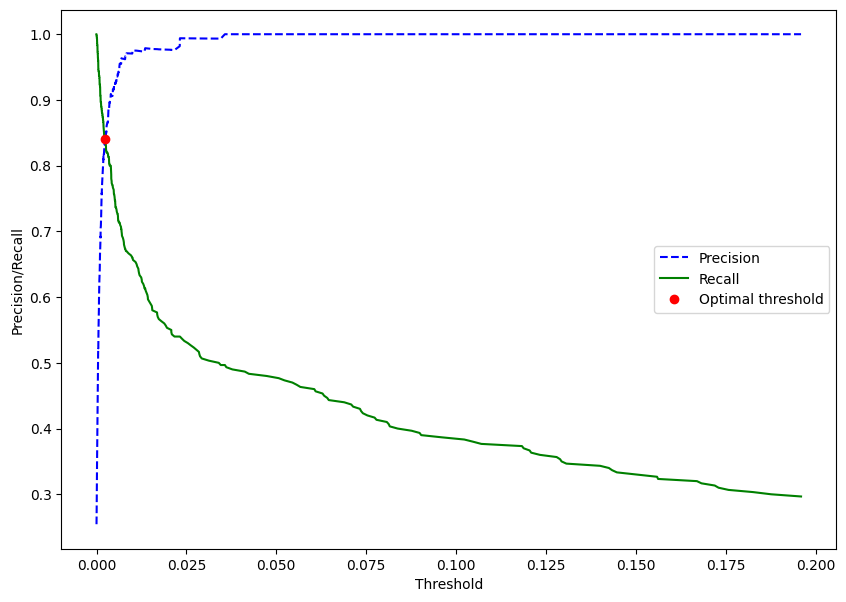

precision:  0.84 ,recall:  0.84
threshold:  0.0023772708005618177


In [191]:
plt.figure(figsize=(10,7))
plt.plot(thresholds[thresholds <= 0.2], precisions[1:][thresholds <= 0.2],"b--", label="Precision")
plt.plot(thresholds[thresholds <= 0.2], recalls[1:][thresholds <= 0.2],"g-", label="Recall")
plt.plot(threshold, precisions[index_cnt], "o", color='r', label="Optimal threshold")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

print('precision: ', precisions[index_cnt],',recall: ',recalls[index_cnt])
print('threshold: ', threshold)

In [192]:
# 테스트 데이터에 대한 재구성 오류
test_x_predictions = loaded_model.predict(X_test)
test_mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


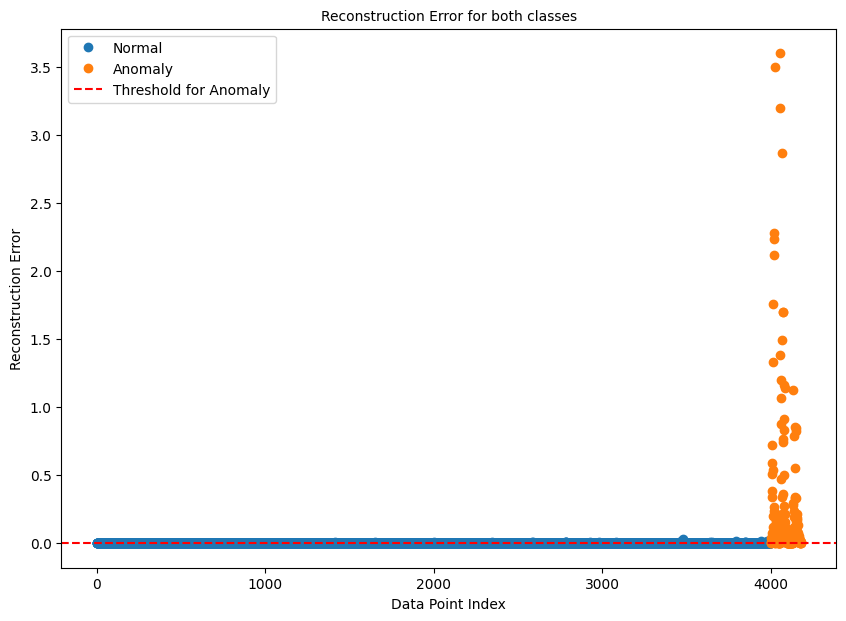

In [193]:
# 설정한 임곗값 검증
plt.figure(figsize=(10,7))
plt.title("Reconstruction Error for both classes", fontsize=10)
plt.plot(np.where(Y_test==0)[0], test_mse[Y_test==0], marker='o', linestyle='', label='Normal')
plt.plot(np.where(Y_test==1)[0], test_mse[Y_test==1], marker='o', linestyle='', label='Anomaly')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold for Anomaly')
plt.xlabel("Data Point Index", fontsize=10)
plt.ylabel("Reconstruction Error", fontsize=10)
plt.legend()
plt.show()

In [198]:
Y_pred = [1 if e > threshold else 0 for e in test_mse]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

[[3903   96]
 [  23  157]]


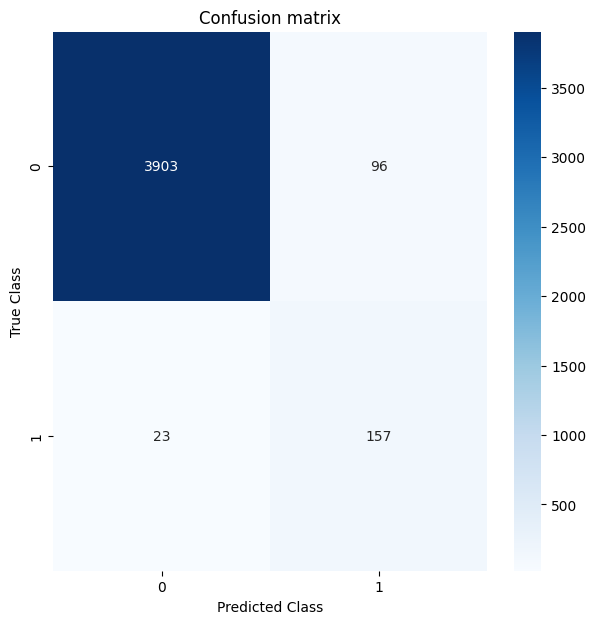

In [200]:
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, xticklabels=[0,1], yticklabels=[0,1], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [201]:
print(classification_report(Y_test, Y_pred, target_names=['정상', '비정상']))

              precision    recall  f1-score   support

          정상       0.99      0.98      0.98      3999
         비정상       0.62      0.87      0.73       180

    accuracy                           0.97      4179
   macro avg       0.81      0.92      0.86      4179
weighted avg       0.98      0.97      0.97      4179



## f1-score 기준

In [202]:
precisions, recalls, thresholds = precision_recall_curve(Y_valid, valid_mse)

In [203]:
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1]
best_f1_idx = np.argmax(f1_scores)

In [205]:
threshold = thresholds[best_f1_idx]
print(f"최적 임계값: {threshold:.6f}")
print(f"해당 지점의 F1-Score: {f1_scores[best_f1_idx]:.4f}")
print(f"재현율: {recalls[best_f1_idx]:.4f}")
print(f"정밀도: {precisions[best_f1_idx]:.4f}")

최적 임계값: 0.004011
해당 지점의 F1-Score: 0.8511
재현율: 0.8000
정밀도: 0.9091


In [206]:
# 찾은 최적 임계값을 기준으로 예측 수행
Y_pred = (test_mse >= threshold).astype(int)

cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[3957   42]
 [  33  147]]


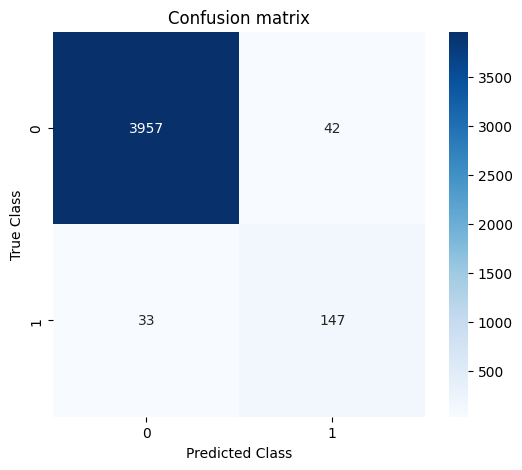

In [207]:
# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, xticklabels=[0,1], yticklabels=[0,1], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [208]:
print(classification_report(Y_test, Y_pred, target_names=['정상', '비정상']))

              precision    recall  f1-score   support

          정상       0.99      0.99      0.99      3999
         비정상       0.78      0.82      0.80       180

    accuracy                           0.98      4179
   macro avg       0.88      0.90      0.89      4179
weighted avg       0.98      0.98      0.98      4179



## 정밀도가 0.8이상이면서 재현율이 가장 높은 값

In [233]:
precisions, recalls, thresholds = precision_recall_curve(Y_valid, valid_mse)

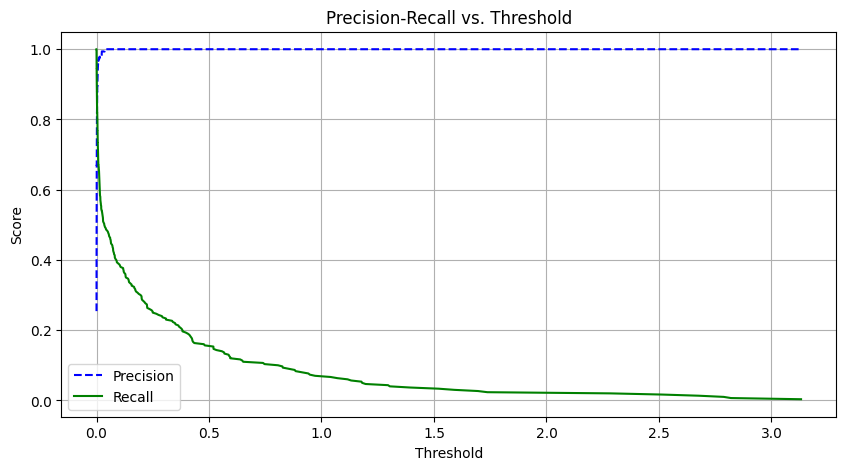

In [234]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title('Precision-Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [248]:
TARGET_PRECISION = 0.85

In [253]:
# 정밀도가 0.85 이상인 모든 지점의 인덱스를 찾음
candidate_indices = np.where(precisions[:-1] >= TARGET_PRECISION)[0]

if len(candidate_indices) == 0:
    print(f"정밀도 {TARGET_PRECISION} 이상을 만족하는 지점을 찾을 수 없습니다.")

else:
    recalls_at_candidates = recalls[candidate_indices]
    best_recall_idx_in_candidates = np.argmax(recalls_at_candidates)

    # 최종 선택된 지점의 원래 인덱스
    final_idx = candidate_indices[best_recall_idx_in_candidates]

    # 최종 임계값
    threshold = thresholds[final_idx]

    # 해당 지점의 성능
    final_precision = precisions[final_idx]
    final_recall = recalls[final_idx]

    print(f"정밀도({TARGET_PRECISION:.2f}) 이상 & 재현율 최대화 조건")
    print(f"최적 임계값: {threshold:.6f}")
    print(f"해당 지점 정밀도: {final_precision:.4f}")
    print(f"해당 지점 재현율: {final_recall:.4f}")

정밀도(0.85) 이상 & 재현율 최대화 조건
최적 임계값: 0.002746
해당 지점 정밀도: 0.8517
해당 지점 재현율: 0.8233


In [254]:
Y_pred = [1 if e > threshold else 0 for e in test_mse]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

[[3924   75]
 [  24  156]]


In [255]:
print(classification_report(Y_test, Y_pred, target_names=['정상', '비정상']))

              precision    recall  f1-score   support

          정상       0.99      0.98      0.99      3999
         비정상       0.68      0.87      0.76       180

    accuracy                           0.98      4179
   macro avg       0.83      0.92      0.87      4179
weighted avg       0.98      0.98      0.98      4179



# 결정된 임곗값 저장

In [256]:
np.save(path+'press_threshold.npy', threshold)